# Modèles de prédiction 

Je propose de résumer ici le travail d'exploration fait dans le premier notebook. 

L'objectif est de prédire deux variables numériques : la consommation d'énergie des bâtiments ```SiteEnergyUse(kBtu)```et la quantité d'émission de CO2 ```CO2_emissions```. Après différents pré-traitements tels que l'élimination des variables corrélées entres elles, ou la vectorisation des variables catégorielles, le jeu d'entrainement a la forme suivante : 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "/home/clairegayral/Documents/openclassroom/data/P3/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P3/"

## my .py : 
from P3_preprocess import *
import missing_values_treatment
import duplicates
import univariate_analysis
from multivariate_analysis import *

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer
from sklearn import linear_model


In [2]:
data = pd.read_csv(res_path+"cleanned_data.csv", index_col=0)
print(len(data.columns[data.dtypes==float])-3, "training numerical variables : ",
      list(data.columns[data.dtypes==float]))
print(len(data.columns[data.dtypes==int]), 
      "training interger variables (from tokenization of categorical variable)")
data.head()

5 training numerical variables :  ['ZipCode', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFAParking', 'LargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'CO2_emissions']
13 training interger variables (from tokenization of categorical variable)


,ZipCode,NumberofBuildings,NumberofFloors,PropertyGFAParking,LargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),CO2_emissions,BuildingType_campus,BuildingType_HR,...,BuildingType_LR,BuildingType_other,PrimaryPropertyType_medical,PrimaryPropertyType_large,PrimaryPropertyType_service,PrimaryPropertyType_other,PrimaryPropertyType_medium,PrimaryPropertyType_empty,PrimaryPropertyType_small,PrimaryPropertyType_other2
0,58091.0,1.0,12.0,0.0,88434.0,62.5,7103895.25,249.705,0,0,...,0,1,0,0,1,0,0,0,0,0
1,58091.0,1.0,11.0,15064.0,83880.0,56.0,8371084.00,279.685,0,0,...,0,1,0,0,1,0,0,0,0,0
2,58091.0,1.0,41.0,98359.0,756868.0,30.5,72858840.00,2075.380,0,0,...,0,1,0,0,1,0,0,0,0,0
3,58091.0,1.0,10.0,0.0,61320.0,28.5,17511952.00,1111.385,0,0,...,0,1,0,0,1,0,0,0,0,0
4,58848.5,1.0,18.0,37230.0,123445.0,71.0,14500852.50,506.355,0,0,...,0,1,0,0,1,0,0,0,0,0


# Mise à l'écart de l'ensemble de test : 
Je mets de côté l'ensemble de test, sur lequel je comparerai mes modèles prédictifs à la fin. 

### Séparation données d'entrainement

In [3]:
from sklearn.model_selection import train_test_split

X_original = data.drop(["SiteEnergyUse(kBtu)","CO2_emissions", "ENERGYSTARScore"], axis = 1)
y_original = data[["SiteEnergyUse(kBtu)","CO2_emissions"]]

X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X_original, y_original, train_size=0.8)

index_train = y_original_train.index
index_test = y_original_test.index

Par soucis de clarté de code, je vais renommer $X\_original\_train$ avec $X$. **Ainsi, le lecteur pourra bien comprendre que le $X$ évoqué dans la suite sera bien l'ensemble d'entrainement.**

In [4]:
X = X_original_train
y = y_original_train

### Standardisation entrainée sur l'ensemble d'entrainement

In [5]:
from sklearn import preprocessing
my_standardizer = preprocessing.StandardScaler()
my_standardizer.fit(X)

## standardization 
my_standardizer.fit(X)
X_std = pd.DataFrame(my_standardizer.transform(X), columns=X.columns, index = X.index)
X_original_test_std = my_standardizer.transform(X_original_test)

## std y ?
my_standardizer.fit(y_original_train)

y_std = pd.DataFrame(my_standardizer.transform(y), columns = y.columns, index = y.index)
y_original_test_std = my_standardizer.transform(y_original_test)

In [6]:
## log-transform :
def df_log_transform(X_):
    num_var = X_.columns[X_.dtypes==float].values
    X_log = X_.copy()
    ## replace neg values with 0 : 
    index_negative = np.where(X_log<0)
    X_log.iloc[[ind for ind in index_negative]] = 0 
    X_log.at[:,num_var] = np.log(X_log[num_var]+1)
    return(X_log)

X_log = df_log_transform(X)

## standardization of log-transfo :
my_standardizer.fit(X_log)
X_log_std = pd.DataFrame(my_standardizer.transform(X_log), columns=X.columns, index = X.index)
X_original_test_log = df_log_transform(X_original_test)
X_original_test_log_std = my_standardizer.transform(X_original_test_log)


# Régression Linéaire

for SiteEnergyUse(kBtu) in log space :


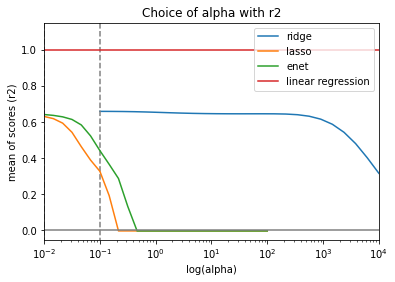

,score,execution_time,best_alpha
lr,1.0,0.009111,None
ridge,0.610482,0.165833,0.1
lasso,0.148139,0.353654,0.01
enet,0.192216,0.343055,0.01


In [7]:
dict_param_grid = {"ridge": np.logspace(-1, 4, 25),
                   "lasso": np.logspace(-2, 2, 25),
                   "enet" : np.logspace(-2, 2, 25),
                  }

dict_models = {"ridge" : linear_model.Ridge(), 
               "lasso" : linear_model.Lasso(),
               "enet" : linear_model.ElasticNet(),
              }

var = "SiteEnergyUse(kBtu)"
X_ = X_log_std
y_ = np.log(y_std[var]+1)
print("for", var, "in log space :")
res = compare_regressions(X_, y_, dict_models, dict_param_grid, score_name="r2", fig_name=None)
plt.show()
res

for CO2_emissions in log space :


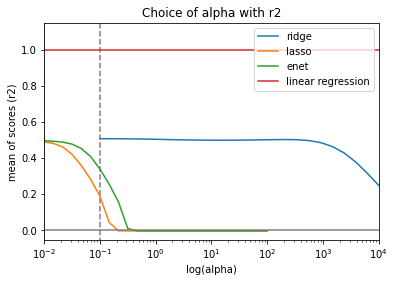

,score,execution_time,best_alpha
lr,1.0,0.01273,None
ridge,0.472946,0.298093,0.1
lasso,0.10487,0.387945,0.01
enet,0.139186,0.222881,0.01


In [8]:
var = "CO2_emissions"
X_ = X_log_std
y_ = np.log(y_std[var]+1)
print("for", var, "in log space :")
res = compare_regressions(X_, y_, dict_models, dict_param_grid, score_name="r2", fig_name=None)
plt.show()
res

La régression linéaire, même avec pénalisation, ne semble pas produire un modèle de prédiction convainquant, notamment à cause de la lourde queue de distribution des variables à prédire. Néansmoins, je vais utiliser la régression pénalisée lasso sur les variables "catégorielles" (issues de la vectorisation de ces dernière pour être précise,  c'est à dire faire une ANOVA), afin de voir si certaines de mes modalités sont non significatives (et peuvent donc être retirées).

for SiteEnergyUse(kBtu) in log space :


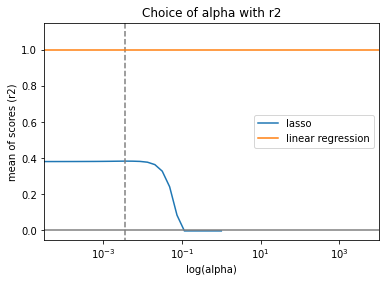

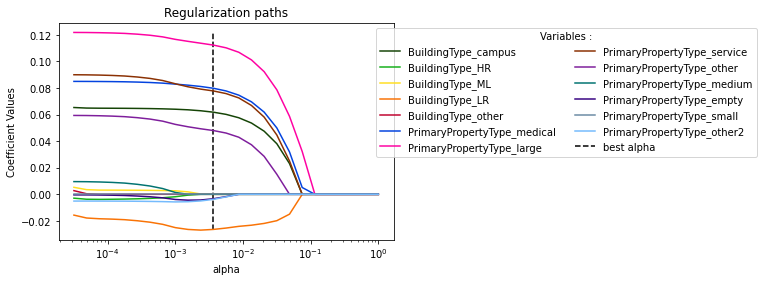

Modalities with zero coefficient in ANOVA :


Index(['BuildingType_HR', 'BuildingType_ML', 'BuildingType_other',
       'PrimaryPropertyType_medium', 'PrimaryPropertyType_small'],
      dtype='object')

In [9]:
dict_param_grid["lasso"] = np.logspace(-4.5, 0, 25)

var = "SiteEnergyUse(kBtu)"
X_ = X_log_std.loc[:,X.dtypes == int]
y_ = np.log(y_std[var]+1)

print("for", var, "in log space :")
res = compare_regressions(X_, y_, {"lasso" : linear_model.Lasso(max_iter=10000)}, 
                          dict_param_grid, score_name="r2", fig_name=None)
plt.show()
## regul paths :
model_name = "lasso"
legend_kwargs = {"loc" : "upper right","bbox_to_anchor":(2.1, 1), "ncol":2}
plot_regul_paths(alpha_values = dict_param_grid[model_name], lm_model = dict_models[model_name], 
                 X_ = X_, y_ = y_, best_alpha=res.loc[model_name, "best_alpha"],
                 var_names = X_.columns, legend_kwargs=legend_kwargs)
plt.show()

model = dict_models[model_name]
model.set_params(alpha = res.loc[model_name, "best_alpha"])
model.fit(X_,y_)
models_coefs = model.coef_
print("Modalities with zero coefficient in ANOVA :")
zero_coeff_modality = X_.columns[[abs(coef) < 10**(-5) for coef in models_coefs]]
zero_coeff_modality

Je vais donc retirer ces méta-modalités, car elle n'ont pas d'influence dans cette ANOVA. 

In [10]:
X = X.drop(zero_coeff_modality.values, axis =1)
X_log = X_log.drop(zero_coeff_modality.values, axis =1)

X_std = X_std.drop(zero_coeff_modality.values, axis = 1)
X_log_std = X_log_std.drop(zero_coeff_modality.values, axis =1)
# X_std = pd.DataFrame(my_standardizer.fit_transform(X), columns=X.columns, index = X.index)

# Liste des modèles testés : 

Pour chacun des modèles de régression testé, j'ai construit un dictionnaire des arguments par défaut (```dict_kwargs_models```). Ce dictionnaire a les mêmes clés "modèles_de_regression" que les dictionnaires ```dict_models``` et ```dict_param_grid```, correspondant respectivement au dictionnaire des fonctions de regression (principalement de sklearn) et des hyper-paramètres à fixer par validation croisée.

Par ailleurs, comme je vais tester plusieurs modèles de régression et certains d'entre eux ne font que de l'univarié, je vais s'éparer la variable de réponse en deux variables. Les données numériques d'entrainement sont passées au log. 

In [11]:
dict_kwargs_models = {}
dict_models = {}
dict_param_grid = {}
dict_log_param = {}

y_co2 = y["CO2_emissions"]
y_energy = y["SiteEnergyUse(kBtu)"]



## 1. Régression à noyaux 

Est-ce que le lien entre les données serait mieux représenté dans un RKHS ? 

Voilà la [page de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html) sur la régression à noyau. 

[Les différents noyaux implémentés dans sklearn](https://scikit-learn.org/stable/modules/metrics.html#metrics)

In [12]:
from sklearn.kernel_ridge import KernelRidge

model_name = "kernel_ridge"

dict_kwargs_models[model_name] = {"alpha":1, "kernel":'linear',"gamma":None,
                                  "degree":3, "coef0":1, "kernel_params":None}
dict_models[model_name] = KernelRidge(**dict_kwargs_models[model_name])
dict_param_grid[model_name] = {"alpha":np.logspace(0, 1.2, 10), # regularisation param
                               "kernel":["linear", "rbf", "polynomial",
                                         "laplacian" ]}
dict_log_param["alpha"] = True
dict_log_param["kernel"] = False

## 2. KNN :
[page sklearn ](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

In [13]:
from sklearn.neighbors import KNeighborsRegressor
model_name = "KNN"

dict_kwargs_models[model_name] = {"n_neighbors":5, "weights":'uniform', "algorithm":'auto',
                                  "leaf_size":30, "p":2, "metric":'minkowski',
                                  "metric_params":None, "n_jobs":None}
dict_models[model_name] = KNeighborsRegressor(**dict_kwargs_models[model_name])
dict_param_grid[model_name] = {"n_neighbors":np.arange(1,15,1)}
dict_log_param["n_neighbors"] = False

## 3. SVM : 
[page sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

In [14]:
from sklearn.svm import SVR
model_name = "SVR"

dict_kwargs_models[model_name] = {"kernel":'rbf', "degree":3, "gamma":'scale',
                          "coef0":0.0, "tol":0.001, "C":1.0, "epsilon":0.1}
dict_models[model_name] = SVR(**dict_kwargs_models[model_name])
dict_param_grid[model_name] = {"C":np.logspace(-1, 3, 10),# regularisation param
                               "epsilon":np.logspace(-2,1,10)}
dict_log_param["C"] = True
dict_log_param["epsilon"] = True

Il faut que je modifie mon format de dict_param_grid pour qu'il devienne dictionnaire de dictionnaire (avec le nom des hyper-params et leur valeurs, pour chaque modèle

Dans [l'aide de la fonction SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html), il y a une exemple d' utilisation de pipeline, à voir si ce n'est pas pertinent pour moi

## 4. Forêts aléatoires
[page sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)

et une [fiche sur les différentes méthodes ensemblistes ](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)

In [15]:
from sklearn.ensemble import RandomForestRegressor 
model_name = "random_forest"

dict_kwargs_models[model_name] = {"n_estimators":100, 
                                  "criterion":'mse', "max_depth":None, 
                                  "min_samples_split":2, "min_samples_leaf":1, 
                                  "min_weight_fraction_leaf":0.0, "max_features":'auto',
                                  "max_leaf_nodes":None, "min_impurity_decrease":0.0,
                                  "min_impurity_split":None, "bootstrap":True, "oob_score":False,
                                  "n_jobs":None, "random_state":None, "verbose":0, 
                                  "warm_start":False, "ccp_alpha":0.0, "max_samples":None}
dict_models[model_name] = RandomForestRegressor(**dict_kwargs_models[model_name])
dict_param_grid[model_name] = {"n_estimators":np.arange(50,250,20)}# regularisation param
dict_log_param["n_estimators"]= False

## 5. Gradient Boosting
[page sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor)

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
model_name = "gradient_boosting"

dict_kwargs_models[model_name]={"loss":'ls', "learning_rate":0.1, "n_estimators":100,
                                "subsample":1.0, "criterion":'friedman_mse', 
                                "min_samples_split":2, "min_samples_leaf":1,
                                "min_weight_fraction_leaf":0.0, "max_depth":3,
                                "min_impurity_decrease":0.0, "min_impurity_split":None,
                                "init":None, "random_state":None, "max_features":None, 
                                "alpha":0.9, "verbose":0, "max_leaf_nodes":None,
                                "warm_start":False, "validation_fraction":0.1, 
                                "n_iter_no_change":None, "tol":0.0001, "ccp_alpha":0.0}

dict_models[model_name] = GradientBoostingRegressor(**dict_kwargs_models[model_name])
dict_param_grid[model_name]={"n_estimators":np.arange(50,250,20), "learning_rate":np.logspace(-2,0.1,10)}
dict_log_param["learning_rate"]= True

# Résultats et interprétation : 
## 1. Hyper-paramètres 

In [17]:
def get_dict_index(res):
    dict_index_values = {}
    for param_name in res["params"][0].keys() : 
        index_values = []
        param_values = np.unique([dict_params[param_name] for dict_params in res["params"] ])
        for value in param_values :
            index_value = [dict_params[param_name] == value for dict_params in res["params"]]
            index_values.append(index_value)
        dict_index_values[param_name] = index_values
    return(dict_index_values)

def get_score_and_time(param_name, res, dict_index_values):
    mean_score_param = []
    time_param = []
    for index_value in dict_index_values[param_name] :
        mean_score_param.append(np.mean(res["mean_test_score"][index_value]))
        time_tmp = (res["mean_fit_time"] + res["mean_score_time"])[index_value]
        time_param.append(np.mean(time_tmp))
    return(mean_score_param,time_param)

def cv_plot_score_and_time(x, y_score, y_time, subplot = [1,2,1],
                           param_name="", x_log_scale = True):
    subplot = subplot.copy()
    plt.subplot(*subplot)
    if x_log_scale : 
        plt.xscale("log")
    plt.plot(x, y_score)
    plt.xlabel("hyperparam. " + param_name)#get param name 
    plt.ylabel("score")
    plt.title("Score in Cross validation")
    subplot[2] += 1
    plt.subplot(*subplot)
    if x_log_scale : 
        plt.xscale("log")
    plt.plot(x, y_time)
    plt.xlabel("hyperparam. " + param_name)#get param name 
    plt.ylabel("time (s)")
    plt.title("Time in Cross validation")

def plot_cv_res(res) :
    dict_index_values = get_dict_index(res)
    nb_params = len(res["params"][0].keys())
    plt.figure(figsize=(12,5*nb_params))
    subplot_pos = [nb_params,2,1]

    for param_name in res["params"][0].keys() :
        x = np.unique([dict_params[param_name] for dict_params in res["params"]])
        y_score, y_time = get_score_and_time(param_name, res, dict_index_values)
        log_flag = dict_log_param[param_name]
        cv_plot_score_and_time(x, y_score, y_time,subplot_pos, 
                               param_name= param_name, x_log_scale=log_flag)
        subplot_pos[2]+= 2

In [ ]:
## some warnings mostly on dual gap
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
cv = 5
dict_cv_results_= {}
dict_best_params = {}
for model_name in dict_models.keys(): 
    print(model_name)
    regressor = dict_models[model_name]
    param_grid = dict_param_grid[model_name]
    CV_regressor = GridSearchCV(regressor, param_grid, refit=True, cv = cv)
    CV_regressor.fit(X, y_co2)
    dict_best_params[model_name] = CV_regressor.best_params_
    res = CV_regressor.cv_results_
    dict_cv_results_[model_name] = res
    plot_cv_res(res)
    plt.show()


kernel_ridge


Gardons donc les meilleurs hyper-paramètres : 

In [ ]:
for model_name in dict_models.keys(): 
    print(model_name)
    cv_results_ = dict_cv_results_[model_name]
#     print(cv_results_["best_params"])
CV_regressor.best_params_

## 2. Choix du modèle 

Les pertes respectives de ces modèles sont : 



# Pistes d'amélioration : 
* la regression linéaire non pénalisée me renvoit des scores trop négatifs -> j'ai fait un hack qui ne garde que les scores positifs, mais par la même occasion rendent les graphiques faux
* faut-il standardiser les variables catégorielles ? -> s'il n'y a que des 0 et 1 on ne gagne rien ?